### Statistical Analysis of the AI grading tool results

#### Part 0: Importing Libraries

In [38]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_rel, wilcoxon, pearsonr, friedmanchisquare, shapiro, kstest, wilcoxon, spearmanr
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#### Part 1: Load and summarise data

In [3]:
# Define paths
base_true_path = "/Users/rrishabh/Documents/Thesis related docs/Thesis Data/Analysis/true_grades.xlsx"
graded_folder_path = "/Users/rrishabh/Documents/Thesis related docs/Thesis Data/Output/H2 experiment results"

# Load base true grades
base_true_df = pd.read_excel(base_true_path)

# Ensure Student IDs are consistent across all DataFrames
base_true_df.set_index('Student ID', inplace=True)

# Load all grading files
graded_files = [os.path.join(graded_folder_path, file) for file in os.listdir(graded_folder_path) if file.endswith('.xlsx')]

# Load each grading file into a dictionary with short names
graded_dfs = {}
for file in graded_files:
    model_rubric_info = file.split("student_grades_")[1].split(".xlsx")[0]
    graded_df = pd.read_excel(file)
    graded_df.set_index('Student ID', inplace=True)
    # Align indices to ensure correct StudentID matching
    graded_dfs[model_rubric_info] = graded_df.reindex(base_true_df.index)

# Summarize Numerical and Theoretical Grades for each graded file
for file_name, df in graded_dfs.items():
    numerical_columns = ['1_Grade', '2_Grade', '3_Grade', '4_Grade', '5_Grade']
    theoretical_columns = ['6_Grade', '7_Grade', '8_Grade', '9_Grade']
    df['numerical_grade'] = df[numerical_columns].sum(axis=1)
    df['theoretical_grade'] = df[theoretical_columns].sum(axis=1)
    df['total_grade'] = df['Total_grade']

In [14]:
# Fixed file path
file_path_analysis = "/Users/rrishabh/Documents/Thesis related docs/Thesis Data/Analysis/comparative_analysis.xlsx"


def save_dataframe_to_excel(df, sheet_name, file_path=file_path_analysis):
    # Check if the file exists
    if os.path.exists(file_path):
        # Append to the existing file
        with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name=sheet_name)
    else:
        # Create a new file and save the sheet
        with pd.ExcelWriter(file_path, mode="w", engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=sheet_name)

#### Part 2: Descriptive Statistics

In [5]:
# Part 2: Descriptive Statistics

# Function to calculate descriptive statistics
def descriptive_stats(df, columns):
    return df[columns].describe().T

# Calculate descriptive statistics for base true grades
base_stats = descriptive_stats(base_true_df, ['numerical_grade', 'theoretical_grade', 'total_grade'])

# Calculate descriptive statistics for each graded file
graded_stats = {file_name: descriptive_stats(df, ['numerical_grade', 'theoretical_grade', 'total_grade']) for file_name, df in graded_dfs.items()}

# Combine all descriptive statistics into a comparative DataFrame
comparative_stats = pd.concat([base_stats] + list(graded_stats.values()), axis=1, keys=['Base_True'] + list(graded_stats.keys()))

In [15]:
save_dataframe_to_excel(comparative_stats, sheet_name="comparative_stats")

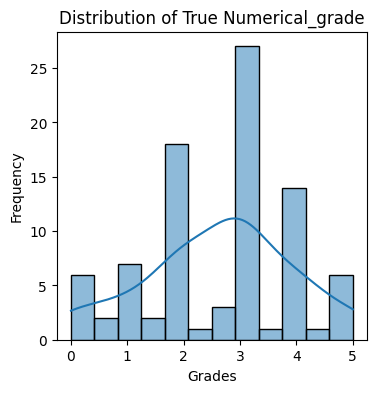

<Figure size 400x400 with 0 Axes>

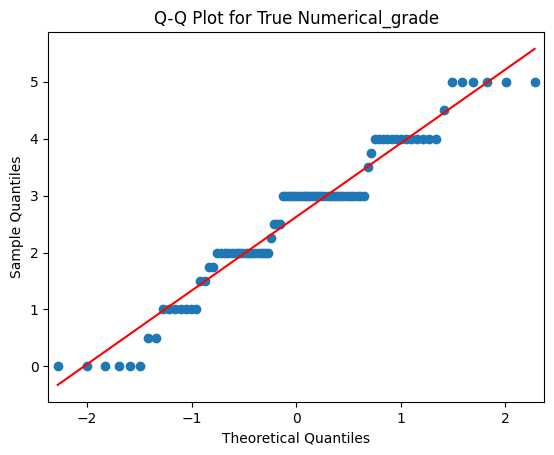

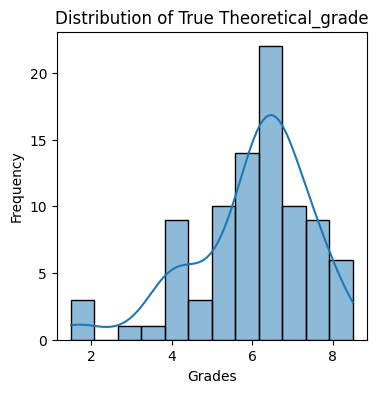

<Figure size 400x400 with 0 Axes>

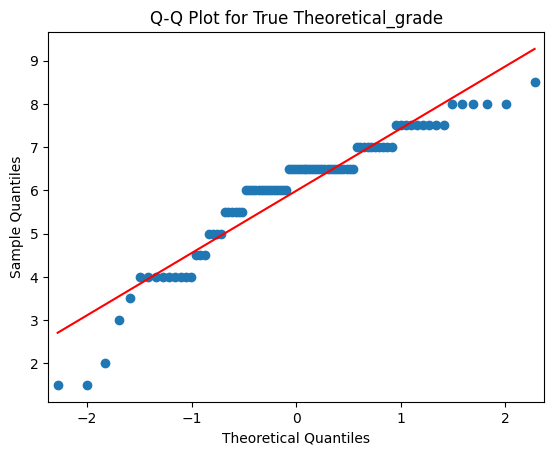

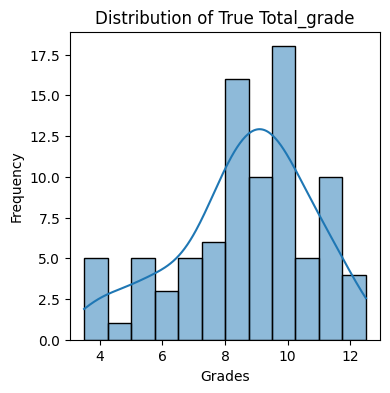

<Figure size 400x400 with 0 Axes>

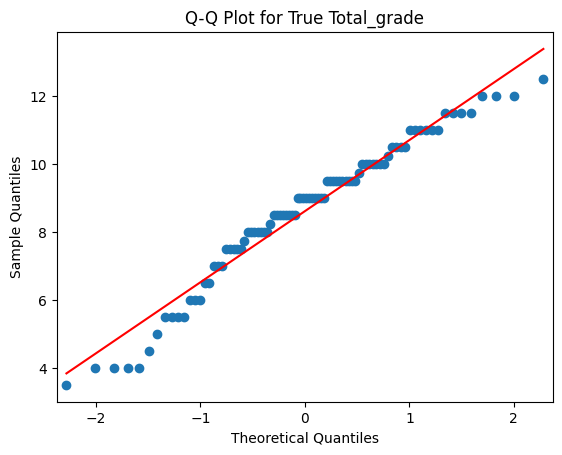

Shapiro-Wilk Test for numerical_grade grades: p-value = 0.0014410108750341618
Shapiro-Wilk Test for theoretical_grade grades: p-value = 1.7845273145954405e-05
Shapiro-Wilk Test for total_grade grades: p-value = 0.008726288513518836


In [132]:
# Distribution Checks on the true grades
# --------------------------------------------------
# Plot histogram and Q-Q plot for true base grades
for grade_type in ['numerical_grade', 'theoretical_grade', 'total_grade']:
    plt.figure(figsize=(4, 4))
    sns.histplot(base_true_df[grade_type], bins=12, kde=True)
    plt.title(f'Distribution of True {grade_type.capitalize()}')
    plt.xlabel('Grades')
    plt.ylabel('Frequency')
    plt.show()

    # Q-Q Plot
    plt.figure(figsize=(4, 4))
    sm.qqplot(base_true_df[grade_type], line='s')
    plt.title(f'Q-Q Plot for True {grade_type.capitalize()}')
    plt.show()

# Shapiro-Wilk Test for normality
for grade_type in ['numerical_grade', 'theoretical_grade', 'total_grade']:
    stat, p_value = shapiro(base_true_df[grade_type])
    print(f'Shapiro-Wilk Test for {grade_type} grades: p-value = {p_value}')

#### Part 3: Error Calculations

In [27]:
# Function to calculate MSE, MAE, and MAPE
def calculate_errors(true_values, predicted_values):
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mae = mean_absolute_error(true_values, predicted_values)
    spearman_corr, _ = spearmanr(true_values, predicted_values)
    non_zero_mask = true_values != 0
    if np.sum(non_zero_mask) > 0:  # Only calculate MAPE if there are non-zero values
        mape = np.mean(np.abs((true_values[non_zero_mask] - predicted_values[non_zero_mask]) / true_values[non_zero_mask])) * 100
    else:
        mape = np.nan
    return rmse, mae, mape, spearman_corr

# Calculate MSE, MAE, and MAPE for each grading file
error_metrics = []
for file_name, df in graded_dfs.items():
    rmse_numerical, mae_numerical, mape_numerical, spearman_corr_num = calculate_errors(base_true_df['numerical_grade'], df['numerical_grade'])
    rmse_theoretical, mae_theoretical, mape_theoretical, spearman_corr_theo = calculate_errors(base_true_df['theoretical_grade'], df['theoretical_grade'])
    rmse_total, mae_total, mape_total, spearman_corr_total = calculate_errors(base_true_df['total_grade'], df['total_grade'])
    error_metrics.append([file_name, rmse_numerical, mae_numerical, mape_numerical, spearman_corr_num, rmse_theoretical, mae_theoretical, mape_theoretical, spearman_corr_theo, rmse_total, mae_total, mape_total, spearman_corr_total])

error_metrics_df = pd.DataFrame(error_metrics, columns=['File', 'RMSE_Num', 'MAE_Num', 'MAPE_Num', 'Corr_Num', 'RMSE_Theo', 'MAE_Theo', 'MAPE_Theo', 'Corr_Theo', 'RMSE_Total', 'MAE_Total', 'MAPE_Total', 'Corr_Total'])


In [28]:
print(error_metrics_df)
save_dataframe_to_excel(error_metrics_df, sheet_name="error_metrics_df")

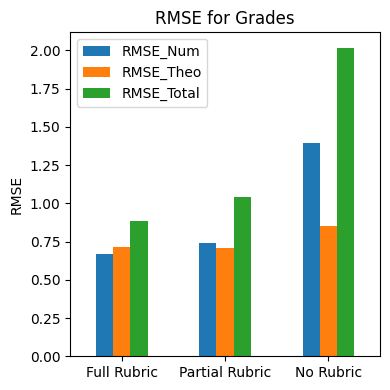

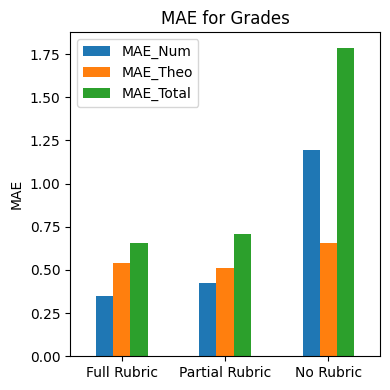

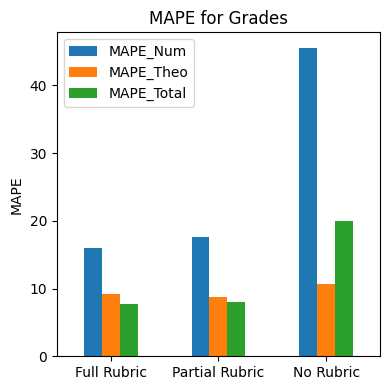

In [126]:
# Visualizations for Comparative Metrics
# --------------------------------------------------
# Separate bar charts for different error metrics
categories = ['Full Rubric', 'Partial Rubric', 'No Rubric']

# Plot RMSE for numerical, theoretical, and total grades
error_metrics_df[['RMSE_Num', 'RMSE_Theo', 'RMSE_Total']].plot(kind='bar', figsize=(4, 4))
plt.title('RMSE for Grades')
plt.ylabel('RMSE')
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=0)
plt.tight_layout()
plt.show()

# Plot MAE for numerical, theoretical, and total grades
error_metrics_df[['MAE_Num', 'MAE_Theo', 'MAE_Total']].plot(kind='bar', figsize=(4, 4))
plt.title('MAE for Grades')
plt.ylabel('MAE')
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=0)
plt.tight_layout()
plt.show()

# Plot MAPE for numerical, theoretical, and total grades
error_metrics_df[['MAPE_Num', 'MAPE_Theo', 'MAPE_Total']].plot(kind='bar', figsize=(4, 4))
plt.title('MAPE for Grades')
plt.ylabel('MAPE')
plt.xticks(ticks=range(len(categories)), labels=categories, rotation=0)
plt.tight_layout()
plt.show()


#### Part 4: Reliability and Correlation Analysis

In [31]:
# Paired t-test and Wilcoxon Signed-Rank Test
paired_test_results = []
for file_name, df in graded_dfs.items():
    t_stat, t_pval = ttest_rel(base_true_df['total_grade'], df['total_grade'])
    w_stat, w_pval = wilcoxon(base_true_df['total_grade'], df['total_grade'])
    paired_test_results.append([file_name, t_stat, t_pval, w_stat, w_pval])

paired_test_results_df = pd.DataFrame(paired_test_results, columns=['File', 'T-Stat', 'T-p-value', 'Wilcox-Stat', 'Wilcox-p-value'])

In [33]:
print(paired_test_results_df)
save_dataframe_to_excel(paired_test_results_df, sheet_name="paired_test_results_df")

In [42]:
# Function to calculate Intraclass Correlation Coefficient (ICC)
def calculate_icc(df_true, df_tool):
    combined_df = pd.DataFrame({
        'Student ID': df_true.index,
        'true_grade': df_true['total_grade'].values,
        'tool_grade': df_tool['total_grade'].values
    })
    
    combined_long_df = combined_df.melt(id_vars='Student ID', 
                                        value_vars=['true_grade', 'tool_grade'],
                                        var_name='Rater', 
                                        value_name='Grade')
    
    icc_results = pg.intraclass_corr(data=combined_long_df, 
                                     targets='Student ID', 
                                     raters='Rater', 
                                     ratings='Grade')
    
    return icc_results

icc_values_rubric = {file_name: calculate_icc(base_true_df, df) for file_name, df in graded_dfs.items()}

In [48]:
print(icc_values_rubric)
for file_name, icc_df in icc_values_rubric.items():
    file_name = "icc" + file_name
    save_dataframe_to_excel(icc_df, sheet_name=file_name, file_path=file_path_analysis)

#### Part 5: Visualisation for experiments so far

In [ ]:
# Assuming `true_grades` and `llm_grades` are your datasets

# Histogram for LLM Generated Grades
for file_name, df in graded_dfs.items():

    sns.histplot(df['total_grade'], bins=20, kde=True)
    plt.title(f'Histogram of {file_name} Grades')
    plt.xlabel('Grades')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

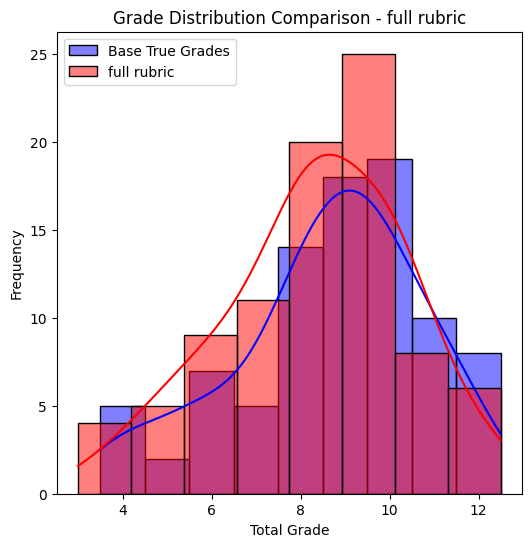

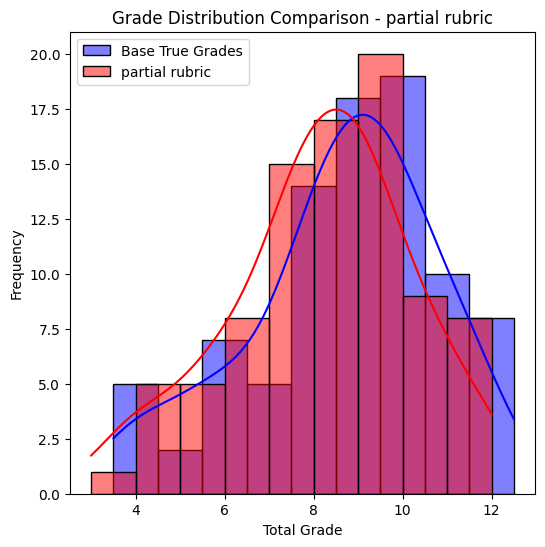

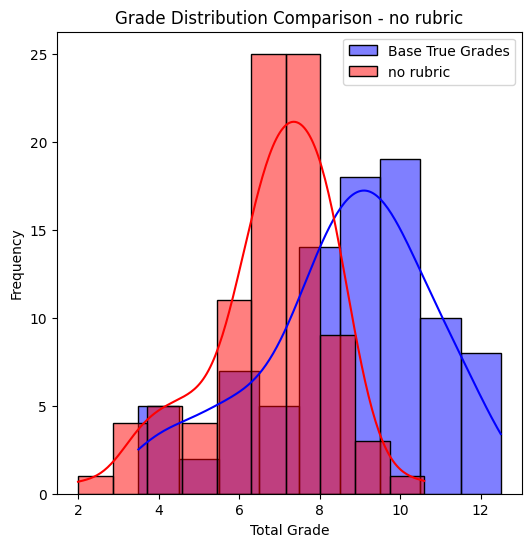

In [119]:
# Define the list of labels for the title and legend
rubric_labels = ["full rubric", "partial rubric", "no rubric"]

# Create a mapping between file names and rubric labels
file_name_to_label = dict(zip(graded_dfs.keys(), rubric_labels))

# Iterate through the graded DataFrames and generate histograms
for file_name, df in graded_dfs.items():
    plt.figure(figsize=(6, 6))
    sns.histplot(base_true_df['total_grade'], color='blue', label='Base True Grades', kde=True)
    sns.histplot(df['total_grade'], color='red', label=file_name_to_label[file_name], kde=True)
    plt.title(f'Grade Distribution Comparison - {file_name_to_label[file_name]}')
    plt.xlabel('Total Grade')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
# Bland-Altman Plot
for file_name, df in graded_dfs.items():
    mean_values = (base_true_df['total_grade'] + df['total_grade']) / 2
    diff_values = base_true_df['total_grade'] - df['total_grade']
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_values, diff_values, alpha=0.5)A
    plt.axhline(np.mean(diff_values), color='red', linestyle='--')
    plt.axhline(np.mean(diff_values) + 1.96*np.std(diff_values), color='blue', linestyle='--')
    plt.axhline(np.mean(diff_values) - 1.96*np.std(diff_values), color='blue', linestyle='--')
    plt.title(f'Bland-Altman Plot - {file_name}')
    plt.xlabel('Mean of True and LLM Grade')
    plt.ylabel('Difference between True and LLM Grade')
    plt.show()

#### Part 6: Consistency Analysis for Multiple Iterations

In [86]:
consistency_folder_path = "/Users/rrishabh/Documents/Thesis related docs/Thesis Data/Output"

# Load consistency grading files
consistency_files = [os.path.join(consistency_folder_path, file) for file in os.listdir(consistency_folder_path) if file.endswith('.xlsx')]

# Load each consistency file into a DataFrame dictionary
consistency_dfs = {}
for i, file in enumerate(consistency_files):
    df = pd.read_excel(file)
    df.set_index('Student ID', inplace=True)
    consistency_dfs[f'iteration_{i+1}'] = df.reindex(base_true_df.index)

# Summarize Numerical and Theoretical Grades for each graded file
for file_name, df in consistency_dfs.items():
    numerical_columns = ['1_Grade', '2_Grade', '3_Grade', '4_Grade', '5_Grade']
    theoretical_columns = ['6_Grade', '7_Grade', '8_Grade', '9_Grade']
    df['numerical_grade'] = df[numerical_columns].sum(axis=1)
    df['theoretical_grade'] = df[theoretical_columns].sum(axis=1)
    df['total_grade'] = df['Total_grade']


##### Part 6.1 Comparative Statistics

In [88]:
# Calculate descriptive statistics for consistency files
consistency_stats = {file_name: descriptive_stats(df, ['numerical_grade', 'theoretical_grade', 'total_grade']) for file_name, df in consistency_dfs.items()}

# Combine all descriptive statistics into a comparative DataFrame
consistency_comparative_stats = pd.concat(list(consistency_stats.values()), axis=1, keys=list(consistency_stats.keys()))

In [89]:
# Display descriptive statistics
print(consistency_comparative_stats)
save_dataframe_to_excel(consistency_comparative_stats, sheet_name="consistency_desc_stats")

In [90]:
# 2. Calculate Coefficient of Variation (CV)
def coefficient_of_variation(df, column):
    return df[column].std() / df[column].mean()

cv_results = {file_name: {col: coefficient_of_variation(df, col) for col in ['numerical_grade', 'theoretical_grade', 'total_grade']} for file_name, df in consistency_dfs.items()}
cv_df_consistency = pd.DataFrame(cv_results)

In [91]:
# Display Coefficient of Variation
save_dataframe_to_excel(cv_df_consistency, sheet_name="consistency_cv_df")
print(cv_df_consistency)

                   iteration_1  iteration_2  iteration_3  iteration_4
numerical_grade       0.544547     0.545313     0.540487     0.556559
theoretical_grade     0.230202     0.229075     0.236305     0.235252
total_grade           0.247336     0.249670     0.253340     0.258147


In [92]:
# 3. Calculate Spearman Correlation between each pair of iterations
spearman_results = {}
iteration_names = list(consistency_dfs.keys())
for i in range(len(iteration_names)):
    for j in range(i + 1, len(iteration_names)):
        file_name_i = iteration_names[i]
        file_name_j = iteration_names[j]
        rho, pval = spearmanr(consistency_dfs[file_name_i]['total_grade'], consistency_dfs[file_name_j]['total_grade'])
        spearman_results[f"{file_name_i} vs {file_name_j}"] = {'Spearman Correlation': rho, 'p-value': pval}

spearman_df = pd.DataFrame(spearman_results).T

In [94]:
# Display Spearman Correlation
save_dataframe_to_excel(spearman_df, sheet_name="consistency_spearman_df")
print(spearman_df)

                            Spearman Correlation       p-value
iteration_1 vs iteration_2              0.981132  3.670146e-63
iteration_1 vs iteration_3              0.979179  2.435130e-61
iteration_1 vs iteration_4              0.963993  3.011537e-51
iteration_2 vs iteration_3              0.988799  7.855422e-73
iteration_2 vs iteration_4              0.969117  4.551698e-54
iteration_3 vs iteration_4              0.973187  1.137034e-56


In [97]:
# 4. Calculate Intraclass Correlation Coefficient (ICC)
def calculate_icc(consistency_dfs):
    # Prepare data for ICC calculation
    combined_df = pd.concat([df['total_grade'].rename(file_name) for file_name, df in consistency_dfs.items()], axis=1)
    combined_long_df = combined_df.melt(ignore_index=False, var_name="Rater", value_name="Grade").reset_index()
    
    # Calculate ICC
    icc_results = pg.intraclass_corr(data=combined_long_df, targets="Student ID", raters="Rater", ratings="Grade")
    return icc_results

consistency_icc_results = calculate_icc(consistency_dfs)

In [98]:
# Display ICC results
save_dataframe_to_excel(consistency_icc_results, sheet_name="consistency_icc_results")
print(consistency_icc_results)

    Type              Description       ICC           F  df1  df2  \
0   ICC1   Single raters absolute  0.978247  180.879053   87  264   
1   ICC2     Single random raters  0.978248  182.749711   87  261   
2   ICC3      Single fixed raters  0.978466  182.749711   87  261   
3  ICC1k  Average raters absolute  0.994471  180.879053   87  264   
4  ICC2k    Average random raters  0.994472  182.749711   87  261   
5  ICC3k     Average fixed raters  0.994528  182.749711   87  261   

            pval         CI95%  
0  2.083750e-195  [0.97, 0.98]  
1  4.038892e-194  [0.97, 0.98]  
2  4.038892e-194  [0.97, 0.98]  
3  2.083750e-195   [0.99, 1.0]  
4  4.038892e-194   [0.99, 1.0]  
5  4.038892e-194   [0.99, 1.0]  


In [104]:
combined_total_grades = pd.concat([df['total_grade'].rename(file_name) for file_name, df in consistency_dfs.items()], axis=1)

In [ ]:
# Violin Plot for Distribution Comparison of Total Grades Across Iterations
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_total_grades, palette="Set3", inner="box", linewidth=1.5)

# Customize plot appearance
plt.title("Distribution of Total Grades Across Iterations", fontsize=16, fontweight="bold")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Total Grade", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


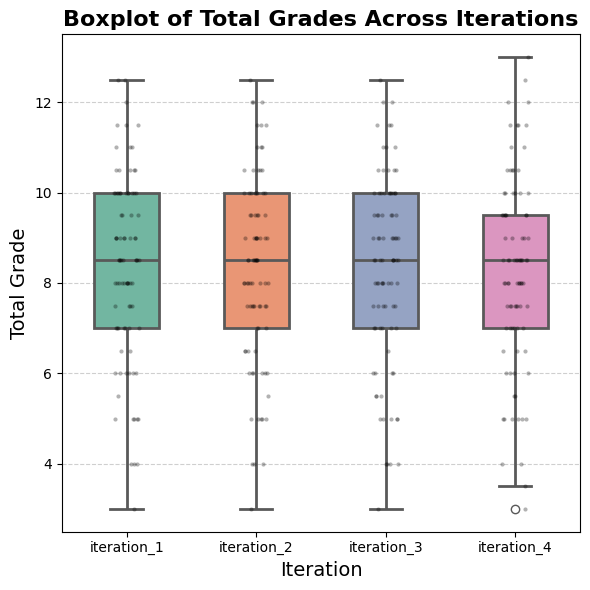

In [108]:
# Enhanced Boxplot of Total Grades across Iterations
plt.figure(figsize=(6, 6))
sns.boxplot(data=combined_total_grades, palette="Set2", width=0.5, linewidth=2)

# Add jittered stripplot for more visual detail on distribution
sns.stripplot(data=combined_total_grades, color="black", alpha=0.3, size=3, jitter=True)

# Customize plot appearance
plt.title("Boxplot of Total Grades Across Iterations", fontsize=16, fontweight="bold")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Total Grade", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

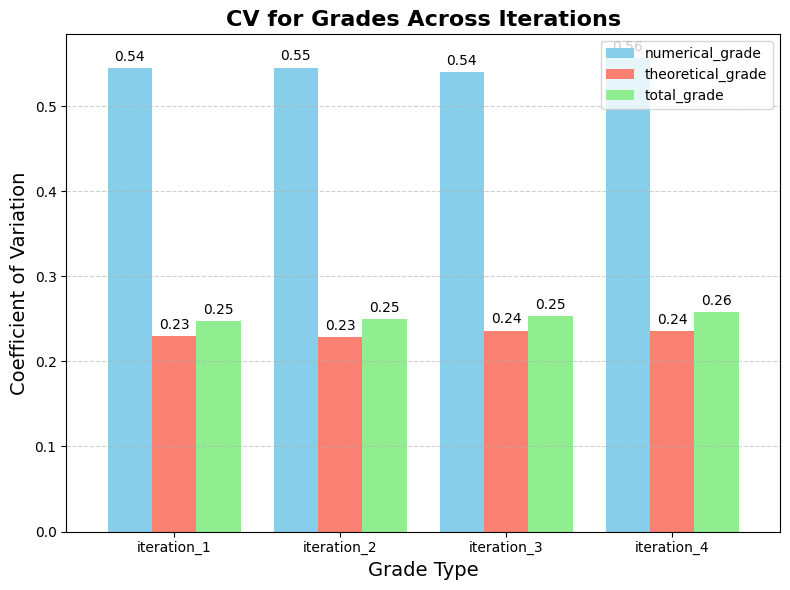

In [114]:
# Enhanced CV Bar Plot with Grouped Bars for Numerical, Theoretical, and Total Grades
cv_df_transposed = cv_df_consistency.T  # Transpose for better grouping by grade type
ax = cv_df_transposed.plot(kind='bar', figsize=(8, 6), width=0.8, color=["skyblue", "salmon", "lightgreen"])

# Set labels and title
plt.title("CV for Grades Across Iterations", fontsize=16, fontweight="bold")
plt.xlabel("Grade Type", fontsize=14)
plt.ylabel("Coefficient of Variation", fontsize=14)
plt.xticks(rotation=0)

# Add data labels on top of bars for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 8), textcoords='offset points', fontsize=10)

plt.legend(title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Coefficient of Variation for Numerical, Theoretical, and Total Grades Across Iterations

In [82]:
# Error Calculations between Consistency Files and True Grades
consistency_error_metrics = []
for file_name, df in consistency_dfs.items():
    rmse_numerical, mae_numerical, mape_numerical, _ = calculate_errors(base_true_df['numerical_grade'], df['numerical_grade'])
    rmse_theoretical, mae_theoretical, mape_theoretical, _ = calculate_errors(base_true_df['theoretical_grade'], df['theoretical_grade'])
    rmse_total, mae_total, mape_total, _ = calculate_errors(base_true_df['total_grade'], df['total_grade'])
    consistency_error_metrics.append([file_name, rmse_numerical, mae_numerical, mape_numerical, rmse_theoretical, mae_theoretical, mape_theoretical, rmse_total, mae_total, mape_total])

consistency_error_metrics_df = pd.DataFrame(consistency_error_metrics, columns=['File', 'RMSE_Numerical', 'MAE_Numerical', 'MAPE_Numerical', 'RMSE_Theoretical', 'MAE_Theoretical', 'MAPE_Theoretical', 'RMSE_Total', 'MAE_Total', 'MAPE_Total'])

#### Part 7: Visualizations for Consistency Analysis

In [ ]:
# Box Plot for Numerical and Theoretical Grades Across Iterations
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.concat([df[['numerical_grade']] for df in consistency_dfs.values()], axis=1))
plt.title('Numerical Grade Distribution Across Iterations')
plt.xlabel('Iterations')
plt.ylabel('Grades')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=pd.concat([df[['theoretical_grade']] for df in consistency_dfs.values()], axis=1))
plt.title('Theoretical Grade Distribution Across Iterations')
plt.xlabel('Iterations')
plt.ylabel('Grades')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

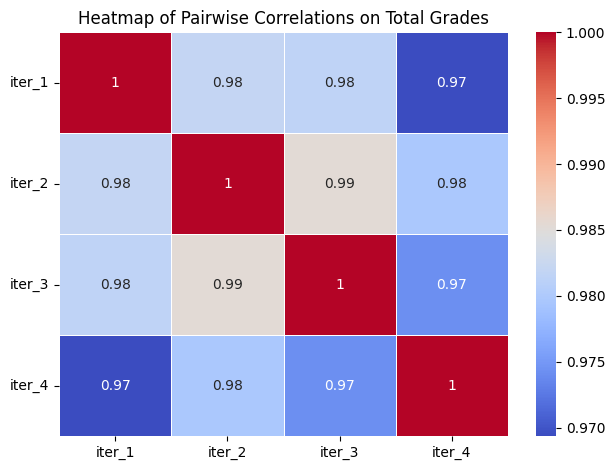

In [136]:
# Calculate the correlation matrix as before
correlation_matrix = pd.concat([df['total_grade'] for df in consistency_dfs.values()], axis=1).corr()

# Plot heatmap with custom axis labels centered on each cell
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Pairwise Correlations on Total Grades')

# Set tick positions at the center of each cell
tick_positions = np.arange(len(correlation_matrix.columns)) + 0.5
plt.xticks(ticks=tick_positions, labels=["iter_1", "iter_2", "iter_3", "iter_4"], ha='center')
plt.yticks(ticks=tick_positions, labels=["iter_1", "iter_2", "iter_3", "iter_4"], rotation=0, va='center')

plt.tight_layout()
plt.show()

In [ ]:
# Bland-Altman Plot for Iterations
for i in range(len(consistency_dfs) - 1):
    df1 = consistency_dfs[f'iteration_{i+1}']
    df2 = consistency_dfs[f'iteration_{i+2}']
    mean_values = (df1['total_grade'] + df2['total_grade']) / 2
    diff_values = df1['total_grade'] - df2['total_grade']
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_values, diff_values, alpha=0.5)
    plt.axhline(np.mean(diff_values), color='red', linestyle='--')
    plt.axhline(np.mean(diff_values) + 1.96*np.std(diff_values), color='blue', linestyle='--')
    plt.axhline(np.mean(diff_values) - 1.96*np.std(diff_values), color='blue', linestyle='--')
    plt.title(f'Bland-Altman Plot - Iteration {i+1} vs Iteration {i+2}')
    plt.xlabel('Mean of Iterations')
    plt.ylabel('Difference between Iterations')
    plt.show()